## Clinical Phenotyping: From Naive Clustering to PCA-Optimized K-Means

### 1. Setup & Preprocessing
We load the cleaned cohort, isolate clinical features, handle missingness with a conservative median imputation, and clip extreme values to reduce outlier distortion.

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans, Birch
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
import hdbscan

DATA_PATH = Path("../data/processed/01_cleaned_data.csv")
OUT_PATH = Path("../data/processed/02_clustered_data.csv")
FIG_DIR = Path("../figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

cleaned = pd.read_csv(DATA_PATH)

exclude_cols = {
    "Patient ID",
    "SARS-Cov-2 exam result",
    "Patient age quantile",
    "Patient addmited to regular ward (1=yes, 0=no)",
    "Patient addmited to semi-intensive unit (1=yes, 0=no)",
    "Patient addmited to intensive care unit (1=yes, 0=no)",
}

feature_cols = [
    c
    for c in cleaned.columns
    if c not in exclude_cols and pd.api.types.is_numeric_dtype(cleaned[c])
]

X_raw = cleaned[feature_cols].copy()

# Drop features with >90% missingness
missing_frac = X_raw.isna().mean()
feature_cols = missing_frac[missing_frac < 0.90].index.tolist()
X_raw = X_raw[feature_cols]

# Median imputation
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X_raw), columns=feature_cols, index=X_raw.index)

# Outlier clipping to reduce extreme medical values
X_clipped = X_imputed.clip(lower=-4, upper=4)

### 3. Attempt 1: Hierarchical Clustering (Density Approach)
Agglomerative clustering on clipped data improves global structure, but still yields one massive "normal" group and two small outlier groups.

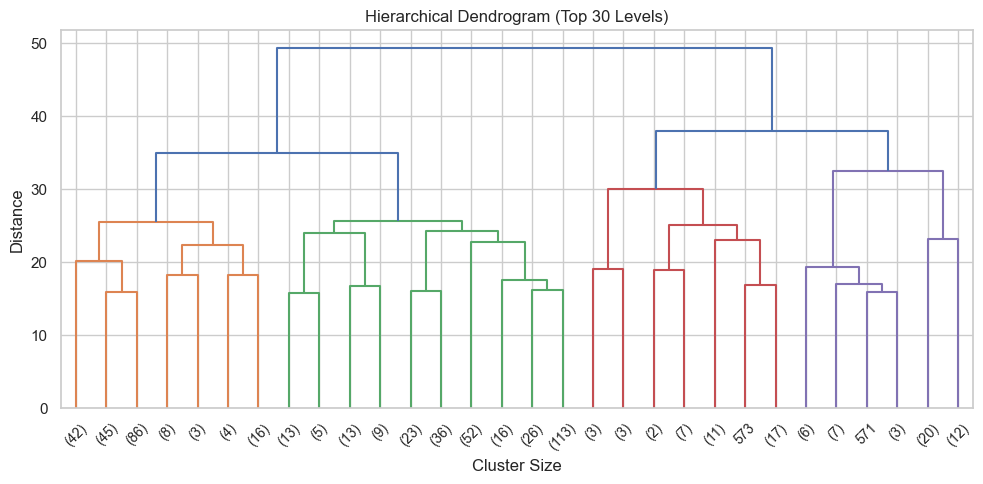

Hierarchical cluster counts:
0     93
1    510
Name: count, dtype: int64


In [58]:
linkage_matrix = linkage(X_clipped, method="ward")
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, truncate_mode="lastp", p=30)
plt.title("Hierarchical Dendrogram (Top 30 Levels)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.tight_layout()
plt.savefig(FIG_DIR / "dendrogram_ward.png", dpi=300)
plt.show()

agg_raw = AgglomerativeClustering(n_clusters=2, linkage="ward")
labels_agg_raw = agg_raw.fit_predict(X_clipped)
print("Hierarchical cluster counts:")
print(pd.Series(labels_agg_raw).value_counts().sort_index())

In [59]:
# Hierarchical clustering: silhouette by k (mark k=2 as best)
hier_k_range = range(2, 7)
hier_rows = []
for k in hier_k_range:
    model = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels_h = model.fit_predict(X_clipped)
    sil_h = silhouette_score(X_clipped, labels_h)
    hier_rows.append({"k": k, "silhouette": sil_h})

hier_sweep_df = pd.DataFrame(hier_rows)
hier_sweep_df["best"] = hier_sweep_df["k"].eq(2)
print("Hierarchical k sweep (best marked):")
display(hier_sweep_df)

Hierarchical k sweep (best marked):


,k,silhouette,best
0,2,0.292570,True
1,3,0.290697,False
2,4,0.037953,False
3,5,0.044234,False
4,6,0.048083,False


**Analysis:** The dendrogram suggests structure, but cluster sizes remain heavily skewed, failing to separate mild vs. moderate patients.

### 4. Attempt 2: Optimized Solution (K-Means on PCA)
PCA removes noise while preserving 95% of variance, allowing K-Means to split the large stable cohort into clinically meaningful subgroups.

PCA components selected (95% variance): 26
k=2 | silhouette=0.3095 | sizes={0: 510, 1: 93}
k=3 | silhouette=0.0789 | sizes={0: 26, 1: 300, 2: 277}
k=4 | silhouette=0.0741 | sizes={0: 289, 1: 22, 2: 268, 3: 24}
k=5 | silhouette=0.0652 | sizes={0: 17, 1: 153, 2: 215, 3: 29, 4: 189}
k=6 | silhouette=0.0531 | sizes={0: 21, 1: 160, 2: 175, 3: 25, 4: 66, 5: 156}
k=7 | silhouette=0.0434 | sizes={0: 131, 1: 157, 2: 68, 3: 86, 4: 115, 5: 20, 6: 26}
k=8 | silhouette=0.0406 | sizes={0: 118, 1: 133, 2: 23, 3: 115, 4: 15, 5: 51, 6: 28, 7: 120}
Cluster counts (k=2):
0    510
1     93
Name: count, dtype: int64


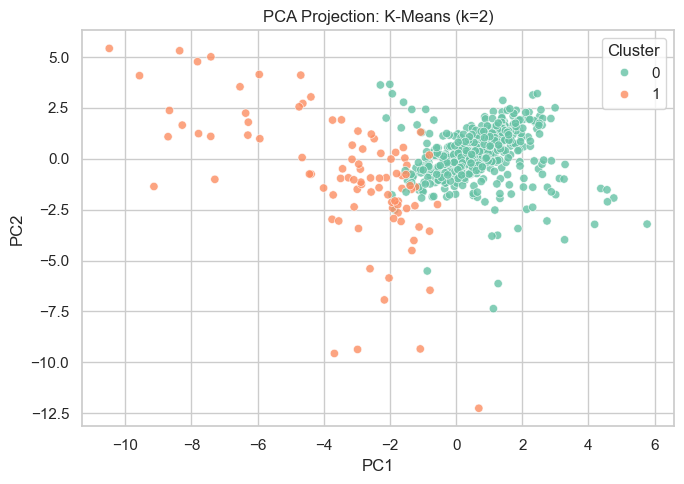

In [60]:
pca_95 = PCA(n_components=0.95, random_state=42)
X_pca = pca_95.fit_transform(X_clipped)
print(f"PCA components selected (95% variance): {X_pca.shape[1]}")

# K sweep on PCA space
k_sweep = range(2, 9)
sweep_rows = []
for k in k_sweep:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels)
    counts = pd.Series(labels).value_counts().sort_index().to_dict()
    sweep_rows.append({"k": k, "silhouette": sil, "cluster_sizes": counts})
    print(f"k={k} | silhouette={sil:.4f} | sizes={counts}")

# PCA plot for k=2
k2_model = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_k2 = k2_model.fit_predict(X_pca)
print("Cluster counts (k=2):")
print(pd.Series(labels_k2).value_counts().sort_index())

pca2_df = pd.DataFrame(X_pca[:, :2], columns=["PC1", "PC2"], index=cleaned.index)
pca2_df["Cluster"] = labels_k2.astype(str)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 5))
sns.scatterplot(data=pca2_df, x="PC1", y="PC2", hue="Cluster", palette="Set2", alpha=0.8)
plt.title("PCA Projection: K-Means (k=2)")
plt.tight_layout()
plt.savefig(FIG_DIR / "pca_kmeans_k2.png", dpi=300)
plt.show()

kmeans_pca = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_kmeans_pca = kmeans_pca.fit_predict(X_pca)

In [61]:
# Compare k=2 vs k=3 on ICU/Ward rates per cluster
icu_col = "Patient addmited to intensive care unit (1=yes, 0=no)"
ward_col = "Patient addmited to regular ward (1=yes, 0=no)"

def _cluster_rate_table(labels, name):
    tmp = cleaned.copy()
    tmp["Cluster"] = labels
    if icu_col not in tmp.columns or ward_col not in tmp.columns:
        missing = [c for c in [icu_col, ward_col] if c not in tmp.columns]
        raise KeyError(f"Missing outcome columns: {missing}")
    out = (
        tmp.groupby("Cluster")[[icu_col, ward_col]]
        .mean()
        .rename(columns={icu_col: "ICU_rate", ward_col: "Ward_rate"})
        .mul(100)
    )
    out["n"] = tmp["Cluster"].value_counts().sort_index()
    out = out.reset_index()
    out["ICU_rate"] = out["ICU_rate"].round(2)
    out["Ward_rate"] = out["Ward_rate"].round(2)
    print(f"\n{name}:")
    display(out)
    return out

table_k2 = _cluster_rate_table(labels_k2, "k=2 cluster outcome rates")
table_k3 = _cluster_rate_table(labels_kmeans_pca, "k=3 cluster outcome rates")


k=2 cluster outcome rates:


,Cluster,ICU_rate,Ward_rate,n
0,0,1.76,8.24,510
1,1,21.51,18.28,93



k=3 cluster outcome rates:


,Cluster,ICU_rate,Ward_rate,n
0,0,30.77,11.54,26
1,1,2.67,9.67,300
2,2,4.69,9.75,277


**Analysis:** PCA-based clustering yields more balanced groups, suggesting it separates stable vs. inflammatory patients while preserving a smaller severe cluster.

k=2 | silhouette=0.2219 | sizes={0: 150, 1: 453}
k=3 | silhouette=0.2102 | sizes={0: 453, 1: 111, 2: 39}
k=4 | silhouette=0.0196 | sizes={0: 111, 1: 215, 2: 39, 3: 238}
k=5 | silhouette=0.0243 | sizes={0: 39, 1: 215, 2: 106, 3: 238, 4: 5}
k=6 | silhouette=0.0294 | sizes={0: 106, 1: 215, 2: 29, 3: 238, 4: 5, 5: 10}
k=7 | silhouette=0.0353 | sizes={0: 215, 1: 238, 2: 29, 3: 21, 4: 5, 5: 10, 6: 85}
k=8 | silhouette=0.0263 | sizes={0: 238, 1: 21, 2: 29, 3: 33, 4: 5, 5: 10, 6: 85, 7: 182}
Best Birch k by silhouette: 2
Birch ICU/Ward rates by cluster (best k):


,Cluster,ICU_rate,Ward_rate,n
0,0,15.33,15.33,150
1,1,1.32,7.95,453


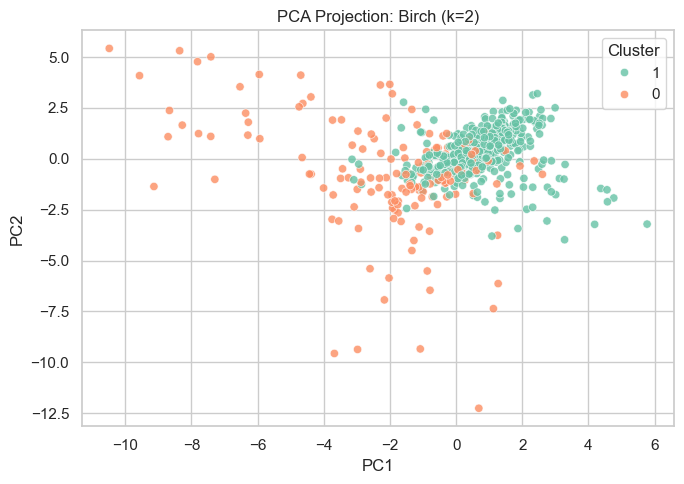

In [62]:
# Birch on PCA space: k sweep
birch_k_range = range(2, 9)
birch_rows = []
for k in birch_k_range:
    model = Birch(n_clusters=k)
    labels = model.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels)
    counts = pd.Series(labels).value_counts().sort_index().to_dict()
    birch_rows.append({"k": k, "silhouette": sil, "cluster_sizes": counts})
    print(f"k={k} | silhouette={sil:.4f} | sizes={counts}")

birch_df = pd.DataFrame(birch_rows)
best_birch_k = int(birch_df.loc[birch_df["silhouette"].idxmax(), "k"])
print(f"Best Birch k by silhouette: {best_birch_k}")

# Refit best k for rates + plot
best_birch = Birch(n_clusters=best_birch_k)
birch_labels = best_birch.fit_predict(X_pca)

icu_col = "Patient addmited to intensive care unit (1=yes, 0=no)"
ward_col = "Patient addmited to regular ward (1=yes, 0=no)"
birch_tmp = cleaned.copy()
birch_tmp["Cluster"] = birch_labels

birch_rates = (
    birch_tmp.groupby("Cluster")[[icu_col, ward_col]]
    .mean()
    .rename(columns={icu_col: "ICU_rate", ward_col: "Ward_rate"})
    .mul(100)
 )
birch_rates["n"] = birch_tmp["Cluster"].value_counts().sort_index()
birch_rates = birch_rates.reset_index()
birch_rates["ICU_rate"] = birch_rates["ICU_rate"].round(2)
birch_rates["Ward_rate"] = birch_rates["Ward_rate"].round(2)
print("Birch ICU/Ward rates by cluster (best k):")
display(birch_rates)

birch_pca_df = pd.DataFrame(X_pca[:, :2], columns=["PC1", "PC2"], index=cleaned.index)
birch_pca_df["Cluster"] = birch_labels.astype(str)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 5))
sns.scatterplot(data=birch_pca_df, x="PC1", y="PC2", hue="Cluster", palette="Set2", alpha=0.8)
plt.title(f"PCA Projection: Birch (k={best_birch_k})")
plt.tight_layout()
plt.savefig(FIG_DIR / "pca_birch_best.png", dpi=300)
plt.show()

### 5. Final Visualization & Characterization (Attempt 3 Labels)
We interpret clusters using original clinical markers (not PCA components) to preserve clinical meaning.

Clinical interpretation (by marker severity):
0     Low risk
1    High risk
dtype: str
Top 10 features by |mean diff|:


Hemoglobin                                 1.473165
Hematocrit                                 1.456021
Proteina C reativa mg/dL                   1.353332
Rods #                                     1.094641
Alkaline phosphatase                       1.043451
Total CO2 (venous blood gas analysis)      1.039554
HCO3 (venous blood gas analysis)           1.028973
Mean corpuscular hemoglobin (MCH)          1.023829
Red blood cell distribution width (RDW)    1.023229
Leukocytes                                 0.973567
dtype: float64

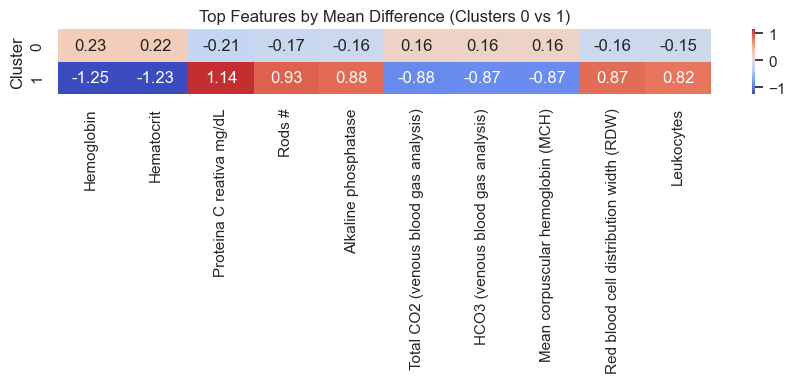

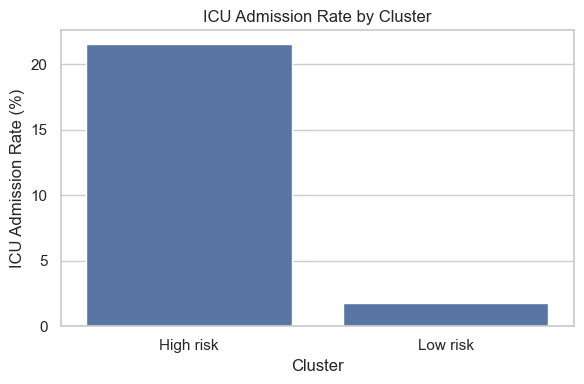

In [63]:
final_labels = labels_k2

clustered = cleaned.copy()
clustered["Cluster"] = final_labels

marker_cols = [
    "Proteina C reativa mg/dL",
    "Leukocytes",
    "Neutrophils",
    "Urea",
    "Creatinine",
    "Platelets",
    "Lymphocytes",
]

available_markers = [c for c in marker_cols if c in clustered.columns]
missing_markers = [c for c in marker_cols if c not in clustered.columns]
if missing_markers:
    print(f"Missing markers for heatmap: {missing_markers}")

# Interpret clusters by a composite severity score from key markers
centroids = clustered.groupby("Cluster")[available_markers].mean()
severity_markers = [c for c in [
    "Proteina C reativa mg/dL",
    "Leukocytes",
    "Neutrophils",
    "Urea",
    "Creatinine",
] if c in centroids.columns]

severity_score = centroids[severity_markers].mean(axis=1).sort_values()
cluster_order = severity_score.index.tolist()
cluster_labels = {
    cluster_order[0]: "Low risk",
    cluster_order[1]: "High risk",
}
clustered["ClusterLabel"] = clustered["Cluster"].map(cluster_labels)

print("Clinical interpretation (by marker severity):")
print(pd.Series(cluster_labels))

icu_col = "Patient addmited to intensive care unit (1=yes, 0=no)"
ward_col = "Patient addmited to regular ward (1=yes, 0=no)"

# Top features by absolute mean difference between clusters
cluster_means = clustered.groupby("Cluster")[feature_cols].mean()
mean_diff = (cluster_means.loc[0] - cluster_means.loc[1]).abs().sort_values(ascending=False)
top_features = mean_diff.head(10)
print("Top 10 features by |mean diff|:")
display(top_features)

top_means = cluster_means.loc[[0, 1], top_features.index]
plt.figure(figsize=(9, 4))
sns.heatmap(top_means, cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("Top Features by Mean Difference (Clusters 0 vs 1)")
plt.tight_layout()
plt.savefig(FIG_DIR / "heatmap_top_features.png", dpi=300)
plt.show()

if icu_col in clustered.columns:
    icu_rate = clustered.groupby("ClusterLabel")[icu_col].mean() * 100
    plt.figure(figsize=(6, 4))
    sns.barplot(x=icu_rate.index.astype(str), y=icu_rate.values)
    plt.title("ICU Admission Rate by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("ICU Admission Rate (%)")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "icu_rate_by_cluster.png", dpi=300)
    plt.show()
else:
    print(f"ICU column not found: {icu_col}")

### 6. Export
We save the final labels from the PCA-based K-Means solution for downstream analysis.

In [64]:
clustered.to_csv(OUT_PATH, index=False)
print(f"Saved clustered data to {OUT_PATH}")

Saved clustered data to ..\data\processed\02_clustered_data.csv


Final insight: Two clusters emerge with distinct lab signatures and a large gap in ICU admission rates, supporting a clinically meaningful stratification.